# Visualizing what convnets learn

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/29<br>
**Last modified:** 2020/05/29<br>
**Description:** Displaying the visual patterns that convnet filters respond to.

## Introduction

In this example, we look into what sort of visual patterns image classification models
learn. We'll be using the `ResNet50V2` model, trained on the ImageNet dataset.

Our process is simple: we will create input images that maximize the activation of
specific filters in a target layer (picked somewhere in the middle of the model: layer
`conv3_block4_out`). Such images represent a visualization of the
pattern that the filter responds to.

## Setup

In [137]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from IPython.display import Image, display


In [138]:
# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"

## Build a feature extraction model

In [139]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [140]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.

In [141]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.

In [142]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.

In [143]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


Let's try it out with filter 0 in the target layer:

In [144]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

This is what an input that maximizes the response of filter 0 in the target layer would
look like:

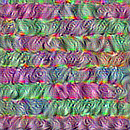

In [145]:
display(Image("0.png"))

## Visualize the first 64 filters in the target layer

Now, let's make a 8x8 grid of the first 64 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

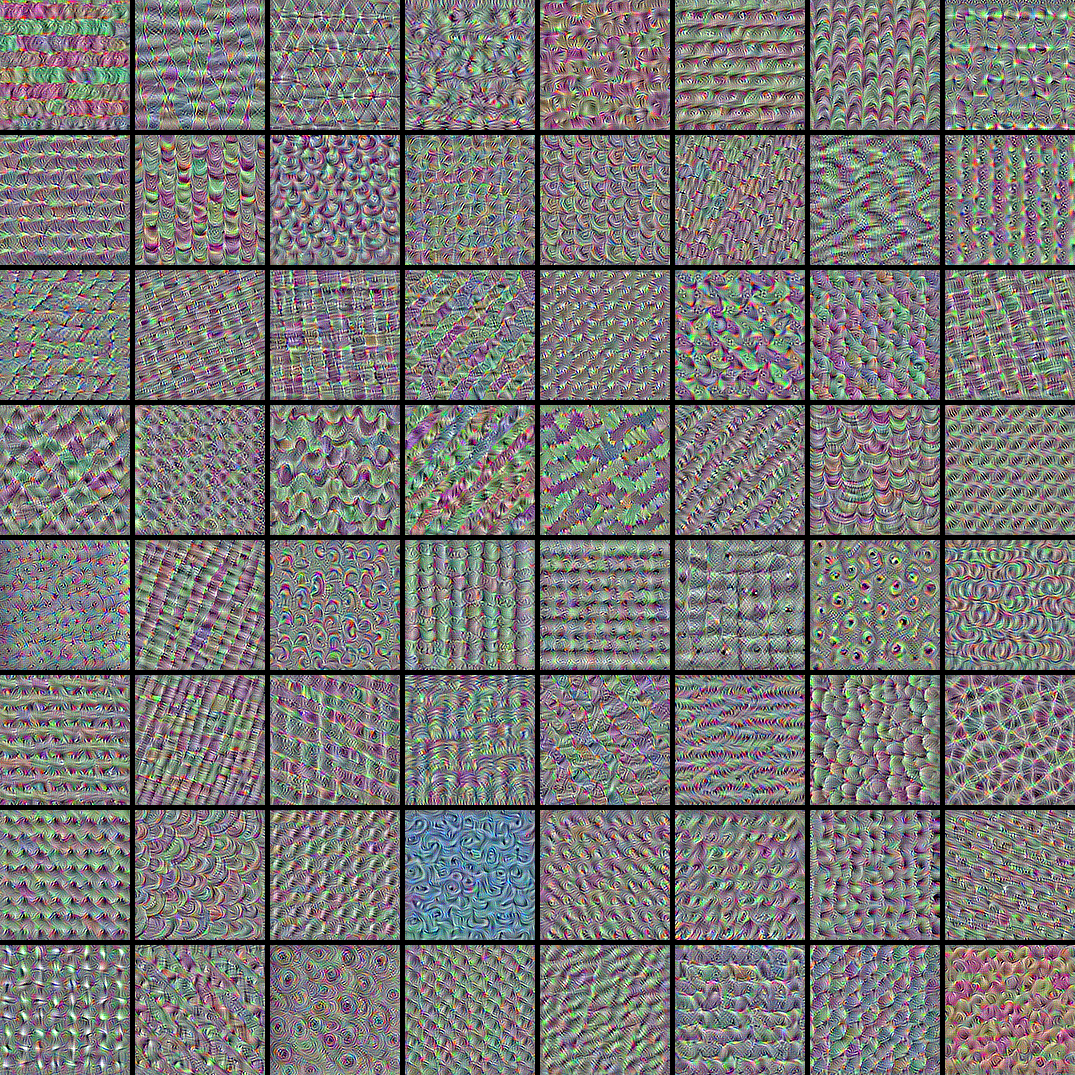

In [8]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

Image classification models see the world by decomposing their inputs over a "vector
basis" of texture filters such as these.

See also
[this old blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
for analysis and interpretation.

Example available on HuggingFace.

[![Generic badge](https://img.shields.io/badge/🤗%20Spaces-What%20Convnets%20Learn-black.svg)](https://huggingface.co/spaces/keras-io/what-convnets-learn)

In [146]:
def make_labels(directory, data=[], y_hat=[], label=0):
    for root, dirs, files in os.walk(directory):
        for file in files:
            img = matplotlib.image.imread(directory+file)
            data.append(img)
        y_hat = [label] * len(data)
    return np.array(data), np.array(y_hat)

In [147]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [148]:
circles, y_circles = [], []
circles, y_circles = make_labels('shapes/circles/', data=circles, y_hat=y_circles)

squares, y_squares = [], []
squares, y_squares = make_labels('shapes/squares/', data=squares, y_hat=y_squares, label=1)

triangles, y_triangles = [], []
triangles, y_triangles = make_labels('shapes/triangles/', data=triangles, y_hat=y_triangles, label=2)

In [149]:
print(circles.shape, squares.shape, triangles.shape)
print(y_circles.shape, y_squares.shape, y_triangles.shape)

(100, 28, 28, 3) (100, 28, 28, 3) (100, 28, 28, 3)
(100,) (100,) (100,)


In [150]:
X, y = np.vstack((circles, squares, triangles)), np.hstack((y_circles, y_squares, y_triangles)).reshape(-1, 1)

In [151]:
model = keras.models.Sequential()
c1 = keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (28, 28, 3), activation = 'relu')
model.add(c1)
c2 = keras.layers.Conv2D(24, (3, 3), padding='same', activation = 'relu')
model.add(c2)
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.5))
c3 = keras.layers.Conv2D(24, (2, 2), padding='same', activation = 'relu')
model.add(c3)
c4 = keras.layers.Conv2D(12, (2, 2), padding='same', activation = 'relu')
model.add(c4)
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
w1 = keras.layers.Dense(units = 50, activation = 'relu')
w2 = keras.layers.Dense(units = 3, activation = 'softmax')
model.add(w1)
model.add(keras.layers.Dropout(0.5)) 
model.add(w2)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 24)        6936      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 24)        2328      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 12)        1164      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 12)         

In [152]:
y_cat = keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42)

In [153]:
model.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [154]:
history = model.fit(X_train, y_train, batch_size=50, epochs=100, verbose=1, 
                   validation_data=(X_test, y_test))

Epoch 1/100
5/5 [==============================] - 1s 44ms/step - loss: 1.1191 - accuracy: 0.3458 - val_loss: 1.0958 - val_accuracy: 0.3667
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 1.1091 - accuracy: 0.3542 - val_loss: 1.0951 - val_accuracy: 0.3667
Epoch 3/100
5/5 [==============================] - 0s 24ms/step - loss: 1.1060 - accuracy: 0.3250 - val_loss: 1.0965 - val_accuracy: 0.4333
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 1.1004 - accuracy: 0.2792 - val_loss: 1.0985 - val_accuracy: 0.3000
Epoch 5/100
5/5 [==============================] - 0s 23ms/step - loss: 1.1031 - accuracy: 0.2917 - val_loss: 1.0966 - val_accuracy: 0.3500
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 1.1011 - accuracy: 0.3208 - val_loss: 1.0976 - val_accuracy: 0.4000
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 1.1082 - accuracy: 0.3083 - val_loss: 1.0987 - val_accuracy: 0.4167
Epoch 8/100
5/5 [===

5/5 [==============================] - 0s 24ms/step - loss: 0.3661 - accuracy: 0.8500 - val_loss: 0.4541 - val_accuracy: 0.8000
Epoch 60/100
5/5 [==============================] - 0s 23ms/step - loss: 0.3467 - accuracy: 0.8667 - val_loss: 0.4725 - val_accuracy: 0.7833
Epoch 61/100
5/5 [==============================] - 0s 24ms/step - loss: 0.3849 - accuracy: 0.8458 - val_loss: 0.4502 - val_accuracy: 0.8000
Epoch 62/100
5/5 [==============================] - 0s 24ms/step - loss: 0.3203 - accuracy: 0.8833 - val_loss: 0.5403 - val_accuracy: 0.7667
Epoch 63/100
5/5 [==============================] - 0s 23ms/step - loss: 0.3741 - accuracy: 0.8500 - val_loss: 0.5585 - val_accuracy: 0.7833
Epoch 64/100
5/5 [==============================] - 0s 23ms/step - loss: 0.3521 - accuracy: 0.8458 - val_loss: 0.4458 - val_accuracy: 0.8000
Epoch 65/100
5/5 [==============================] - 0s 24ms/step - loss: 0.3624 - accuracy: 0.8625 - val_loss: 0.4263 - val_accuracy: 0.8000
Epoch 66/100
5/5 [========

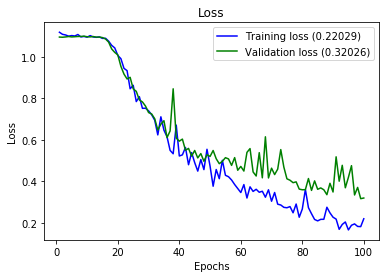

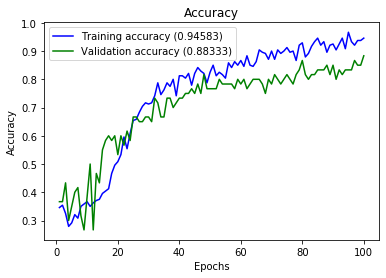

In [155]:
plot_history(history)

In [284]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    print(activation.shape)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [219]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    print(activation.shape)
    filter_activation = activation[:, filter_index]
    return tf.reduce_mean(filter_activation)


In [297]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [298]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return img  * 0.2


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 100
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    #img = deprocess_image(img[0].numpy())
    return loss, img[0].numpy()


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    print(img)

    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    print(img)

    return img


In [247]:
img_width = 28
img_height = 28
layer_name = "dense_3"

In [248]:
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [249]:

loss, img = visualize_filter(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


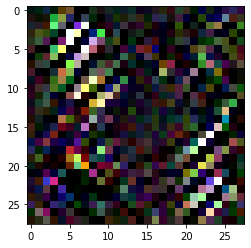

In [250]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


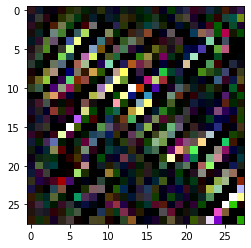

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.0000000e+00 2.9859664e-34 2.7577468e-11]]


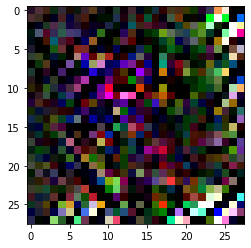

[[2.7467796e-23 1.0000000e+00 8.0772223e-27]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


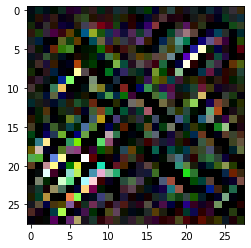

[[3.7067623e-28 0.0000000e+00 1.0000000e+00]]


In [251]:
for i in range(3):
    loss, img = visualize_filter(i)
    plt.imshow(img)
    plt.show()
    print(model.predict(np.array([img])))

In [295]:
img_width = 28
img_height = 28
layer_name = "conv2d_6"

In [296]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    print(activation.shape)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [299]:
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [300]:
loss, img = visualize_filter(0)

(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


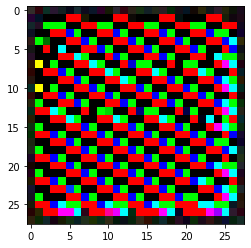

In [301]:
plt.imshow(img)

In [302]:
print(model.predict(np.array([img])))

[[0. 0. 1.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)
(1, 28, 28, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


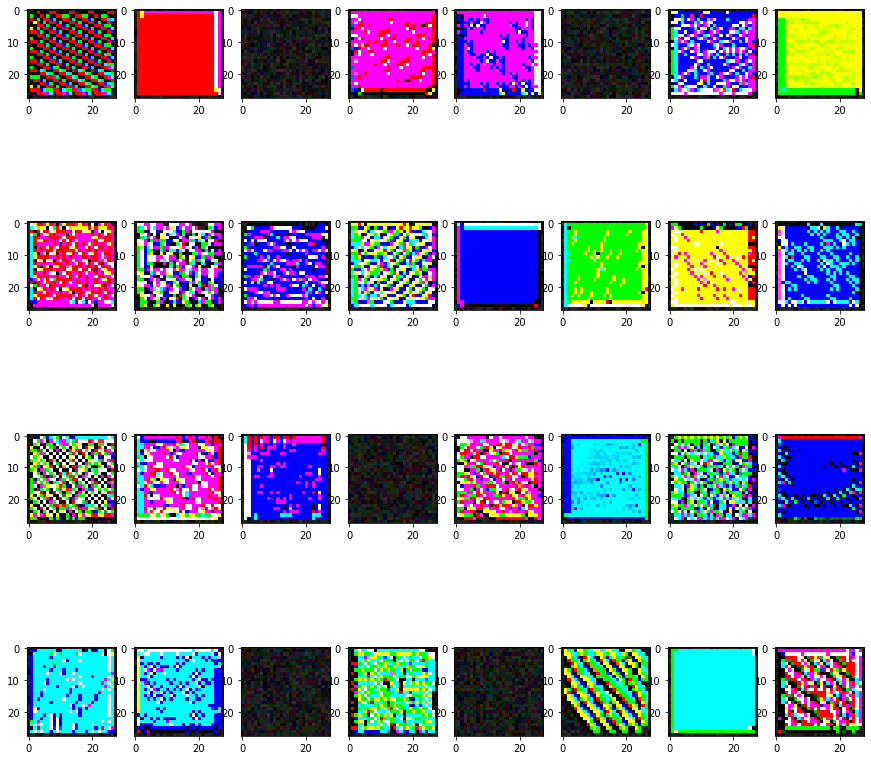

In [303]:
fig, ax = plt.subplots(4,8, figsize=(15, 15))
for i in range(32):
    loss, img = visualize_filter(i)
    ax[i//8,i%8].imshow(img)